# PicsArt AI Hackathon Online

## Детектирование фона на изображениях

In [7]:
%pylab inline

import os
import tqdm

import pandas as pd
from imgaug import augmenters as iaa
from PIL import Image
from skimage.morphology import remove_small_objects, remove_small_holes

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34
from livelossplot import PlotLosses

from utils import rle_encode

from matplotlib import pyplot as plt
from PIL import ImageFilter
import cv2
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)

device = torch.device("cuda:0")

%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
AUGMENT = Compose([
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                RandomRotate90(p=0.5),
                RandomRotate90(p=0.1),
                Transpose(p=0.5),
                CenterCrop(p=0.45, height=320, width=320),
                
        ])

In [9]:
path_images = list(map(
    lambda x: x.split('.')[0],
    filter(lambda x: x.endswith('.jpg'), os.listdir('data/train/'))))

train_images, val_images = path_images[:-500], path_images[-500:]

In [10]:
class FaceDataset(Dataset):
    def __init__(self, images_dir, images_name, target_dir=None,
                 transforms=None, augmentation=True):
        
        self.images_dir = images_dir
        self.target_dir = target_dir
        self.images_name = images_name
        self.transforms = transforms
        self.augmentation = augmentation
                           
        print('{} images'.format(len(self.images_name)))

    def __len__(self):
        return len(self.images_name)
               
    def __getitem__(self, idx):
        img_filename = os.path.join(
            self.images_dir, self.images_name[idx] + '.jpg')
        img = Image.open(img_filename)
        
        if self.target_dir:
            mask_filename = os.path.join(
                self.target_dir, self.images_name[idx] + '.png')
            mask = Image.open(mask_filename)
        else:
            mask = []
        
        if self.transforms:
            background = Image.new('RGB', (320, 320))
            background.paste(img)
            img = background
            
            if mask:
                background = Image.new('RGB', (320, 320))
                background.paste(mask)
                mask = background
                
                if self.augmentation:
                    aug = AUGMENT(image=np.array(img),
                                   mask=np.array(mask))

                    img = Image.fromarray(aug["image"])
                    mask = Image.fromarray(aug["mask"])
                
                mask = transforms.ToTensor()(mask)
            
                
            img = self.transforms(img)
        return {'img': img, 'mask': mask}

In [11]:
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

In [12]:
train_dataset = FaceDataset(
    images_dir='data/train/',
    images_name=train_images,
    target_dir='data/train_mask/',
    transforms=image_transforms)

val_dataset = FaceDataset(
    images_dir='data/train/',
    images_name=val_images,
    target_dir='data/train_mask/',
    transforms=image_transforms)


train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=4)

991 images
500 images


In [13]:
a = train_dataset[0]

In [14]:
class ResNetEncoder(nn.Module):
    def __init__(self, arch, pretrained=False):
        super().__init__()

        backbone = arch(pretrained=pretrained)

        self.encoder0 = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool
        )
        self.encoder1 = backbone.layer1
        self.encoder2 = backbone.layer2
        self.encoder3 = backbone.layer3
        self.encoder4 = backbone.layer4

        self.filters = [
            module[-1].conv3.out_channels
            if 'conv3' in module[-1].__dict__['_modules']
            else module[-1].conv2.out_channels
            for module in [
                self.encoder1,
                self.encoder2,
                self.encoder3,
                self.encoder4
            ]
        ]

    def forward(self, x):
        acts = []
        x = self.encoder0(x)
        x = self.encoder1(x)
        # print(x.shape)
        acts.append(x)
        x = self.encoder2(x)
        # print(x.shape)
        acts.append(x)
        x = self.encoder3(x)
        # print(x.shape)
        acts.append(x)
        x = self.encoder4(x)
        # print(x.shape)
        acts.append(x)
        return acts


class DecoderBlock(nn.Module):
    def __init__(self, m, n, stride=2):
        super().__init__()

        # B, C, H, W -> B, C/4, H, W
        self.conv1 = nn.Conv2d(m, m // 4, 1)
        self.norm1 = nn.BatchNorm2d(m // 4)
        self.relu1 = nn.ReLU(inplace=False)

        # B, C/4, H, W -> B, C/4, H, W
        self.conv2 = nn.ConvTranspose2d(m // 4, m // 4, 3, stride=stride, padding=1)
        self.norm2 = nn.BatchNorm2d(m // 4)
        self.relu2 = nn.ReLU(inplace=False)

        # B, C/4, H, W -> B, C, H, W
        self.conv3 = nn.Conv2d(m // 4, n, 1)
        self.norm3 = nn.BatchNorm2d(n)
        self.relu3 = nn.ReLU(inplace=False)

    def forward(self, x):
        double_size = (x.size(-2) * 2, x.size(-1) * 2)
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.conv2(x, output_size=double_size)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        return x


class FinalBlock(nn.Module):
    def __init__(self, num_filters, num_classes=2):
        super().__init__()

        self.conv1 = nn.ConvTranspose2d(num_filters, num_filters // 2, 3, stride=2, padding=1)
        self.relu1 = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(num_filters // 2, num_filters // 2, 3, padding=1)
        self.relu2 = nn.ReLU(inplace=False)
        self.conv3 = nn.Conv2d(num_filters // 2, num_classes, 1)

    def forward(self, inputs):
        double_size = (inputs.size(-2) * 2, inputs.size(-1) * 2)
        x = self.conv1(inputs, output_size=double_size)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        return x


class LinkNet(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()

        self.encoder = encoder
        filters = self.encoder.filters

        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        self.final = FinalBlock(filters[0], num_classes)

    def forward(self, x):
        e1, e2, e3, e4 = self.encoder(x)
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        out = self.final(d1)
        out = out.squeeze(1)  # FIXME ugly 2
        return out


def linknet18(num_classes=1, pretrained=False):
    encoder = ResNetEncoder(resnet18, pretrained=pretrained).to(device)
    return LinkNet(encoder, num_classes)


def linknet34(num_classes=1, pretrained=False):
    encoder = ResNetEncoder(resnet34, pretrained=pretrained).to(device)
    return LinkNet(encoder, num_classes).to(device)

In [15]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = F.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

In [16]:
unet = linknet34(pretrained=True).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
val_criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(unet.parameters(), lr=0.0002)

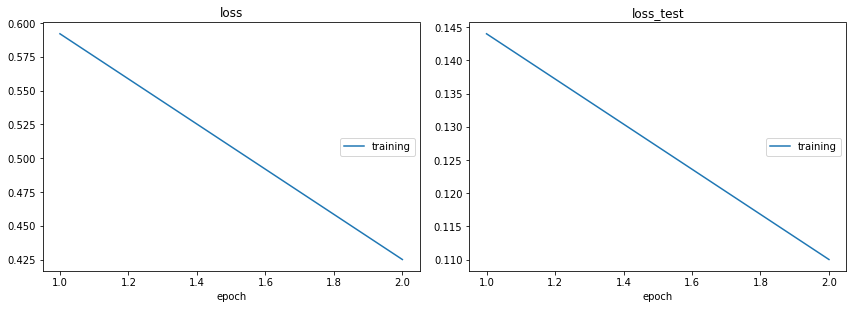

In [ ]:
plot = PlotLosses()
num_epoch = 300
steps = 40

for epoch in range(num_epoch):
    for i, batch in enumerate(train_data_loader):
        optimizer.zero_grad()
        output = unet(batch['img'].to(device))
        loss = criterion(output, batch['mask'][:,0,:,:].to(device))
        loss.backward()
        optimizer.step()
        steps += 1
        
        if steps % 10 == 0:
            val_loss = 0
            for i, batch in enumerate(val_data_loader):
                output = unet(batch['img'].to(device))
                val_loss += float(
                    val_criterion(output, batch['mask'][:,0,:,:].to(device)).detach())
            val_loss = val_loss / len(val_dataset)
            plot.update({
                "loss": round(float(loss.detach()), 3),
                "loss_test": round(val_loss, 3)
            })
            
            plot.draw()

In [ ]:
threshold = 0.5
predictions = []


path_images = list(map(
    lambda x: x.split('.')[0],
    filter(lambda x: x.endswith('.jpg'), os.listdir('data/test/'))))

test_data_loader = DataLoader(
    FaceDataset('data/test', path_images, transforms=image_transforms, augmentation=False), batch_size=4)

test_dataset = FaceDataset('data/test', path_images, transforms=image_transforms)

for batch in tqdm.tqdm_notebook(test_data_loader):
    output = torch.sigmoid(unet.forward(batch['img'].to(device))).cpu()
    for i in range(output.shape[0]):
        img = output[i].detach().numpy()
        post_img = remove_small_holes(remove_small_objects(img > threshold))[:,:240]
        rle = rle_encode(post_img)
        predictions.append(rle)

In [ ]:
image_id = 0

plt.imshow(post_img)
plt.show()
plt.imshow(np.moveaxis(batch["img"][0].cpu().data.numpy()[:,:,:240], [0,1,2], [2,0,1]))
plt.show()

In [ ]:
df = pd.DataFrame.from_dict({'image': path_images, 'rle_mask': predictions})
df.to_csv('submission.csv', index=False)

## Testing

In [ ]:
threshold = 0.5

image_name = "test-putin.jpg"
masks = []

for i in [0, 90, 180, 270]:
    
    test_img = Image.open(image_name).rotate(i)
    inference_transform = transforms.Compose([transforms.CenterCrop(min(test_img.size)),
                                                transforms.Resize((320,320))])

    test_img = inference_transform(test_img)
    img = image_transforms(test_img).unsqueeze(0).to(device)


    mask = torch.sigmoid(unet.forward(img)).cpu().detach().numpy()[0]
    mask = remove_small_holes(remove_small_objects(mask > threshold))

    mask = (mask).astype("uint8") * 255
    mask = Image.fromarray(mask)
    masks.append(mask.rotate(360-i))
    
for i in [0, 90, 180, 270]:
    
    test_img = Image.open(image_name).rotate(i).transpose(0)
    inference_transform = transforms.Compose([transforms.CenterCrop(min(test_img.size)),
                                                transforms.Resize((320,320))])

    test_img = inference_transform(test_img)
    img = image_transforms(test_img).unsqueeze(0).to(device)


    mask = torch.sigmoid(unet.forward(img)).cpu().detach().numpy()[0]
    mask = remove_small_holes(remove_small_objects(mask > threshold))

    mask = (mask).astype("uint8") * 255
    mask = Image.fromarray(mask)
    masks.append(mask.transpose(0).rotate(360-i))


mask = np.max([np.array(i) for i in masks], axis=0)
mask = mask/mask.max();
mask = mask.astype("uint8") * 255
mask = Image.fromarray(mask)

In [ ]:
test_img = Image.open(image_name)
inference_transform = transforms.Compose([transforms.CenterCrop(min(test_img.size)),
                                            transforms.Resize((320,320))])

test_img = inference_transform(test_img)
img = image_transforms(test_img).unsqueeze(0).to(device)
test_img

In [ ]:
image = Image.new("RGB", (320, 320))
image.paste(test_img)
image = image.filter(ImageFilter.GaussianBlur(radius=4))
image.paste(test_img, mask)
image

In [ ]:
masks[0]